## Build Precision Recall Curve: 

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
from collections import Counter
import matplotlib.pyplot as plt

#### Functions: builds the dataframe of Node, scores, and label - needed to build the PRC

In [2]:
def build_prc_df(ensemble_df, go_ensemble_list):
    go_ensemble_prc_df = ensemble_df.copy()
    go_ensemble_prc_df['y_go'] = 0
    go_ensemble_prc_df.loc[go_ensemble_prc_df['Node'].isin(go_ensemble_list), 'y_go'] = 1
    # go0000398_ensemble05_prc_df.head()
    return go_ensemble_prc_df

##### Function: builds the dataframe that lists the number of times each biological process shows up in the overlap of ensemble pathways and the particular GO term

In [3]:
def build_biological_process_count_df(go_ensemble_prc_df, go_df):
    overlap_df = go_ensemble_prc_df[go_ensemble_prc_df['y_go'] == 1].reset_index().drop('index', axis=1)
    print(len(overlap_df))
    merged_df = pd.merge(overlap_df, go_df, left_on='Node', right_on='Entry Name')
    biological_processes = merged_df['Gene Ontology (biological process)']
    # expand the list of biological processes on ';' char
    biological_processes_go = [element.strip() for string in biological_processes for element in string.split(';')]
    # build count df
    df = pd.DataFrame(biological_processes_go, columns=['Element'])
    go_count_df = df['Element'].value_counts().reset_index()
    go_count_df.columns = ['Element', 'Count']
    return go_count_df

## Part 1: Compare SPRAS hiv05 max node frequency and GO terms

### Load hiv05 max ensemble node frequency

In [4]:
ensemble05_df = pd.read_csv("C:/Users/sumed/BDS-SROP-24/spras_processed_data/hiv05-max-node-freq-ensemble.csv")
ensemble05_df.head()

,Node,max_freq
0,1433B_HUMAN,0.16
1,1433E_HUMAN,0.16
2,1433G_HUMAN,0.16
3,1433S_HUMAN,0.12
4,1433T_HUMAN,0.16


In [5]:
ensemble05_proteins_list = ensemble05_df['Node']
len(ensemble05_proteins_list)

1237

### 5 min: GO term --> mRNA splicing, via spliceosome (GO:0000398)

In [6]:
go0000398_path = "C:/Users/sumed/BDS-SROP-24/spras_raw_data/uniprotkb_go_0000398_AND_taxonomy_id_96_2024_07_25.tsv"
go0000398_df = pd.read_csv(go0000398_path, sep='\t')
go0000398_df.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Gene Ontology (biological process)
0,O00148,reviewed,DX39A_HUMAN,ATP-dependent RNA helicase DDX39A (EC 3.6.4.13...,DDX39A DDX39,mRNA export from nucleus [GO:0006406]; mRNA sp...
1,O14744,reviewed,ANM5_HUMAN,Protein arginine N-methyltransferase 5 (PRMT5)...,PRMT5 HRMT1L5 IBP72 JBP1 SKB1,chromatin remodeling [GO:0006338]; circadian r...
2,O14893,reviewed,GEMI2_HUMAN,Gem-associated protein 2 (Gemin-2) (Component ...,GEMIN2 SIP1,mRNA processing [GO:0006397]; negative regulat...
3,O15234,reviewed,CASC3_HUMAN,Protein CASC3 (Cancer susceptibility candidate...,CASC3 MLN51,intracellular mRNA localization [GO:0008298]; ...
4,O15541,reviewed,R113A_HUMAN,E3 ubiquitin-protein ligase RNF113A (EC 2.3.2....,RNF113A RNF113 ZNF183,"DNA repair [GO:0006281]; mRNA splicing, via sp..."


In [7]:
go0000398_proteins_list = go0000398_df['Entry Name']
print("Number of proteins in GO:0000398 and human taxonomy: ", len(go0000398_proteins_list))
go0000398_ensemble05 = list(set(go0000398_proteins_list) & set(ensemble05_proteins_list))
print("Number of proteins in GO:0000398 and human taxonomy, intersected with SPRAS hiv05 ensemble pathway nodes: ", len(go0000398_ensemble05))

Number of proteins in GO:0000398 and human taxonomy:  677
Number of proteins in GO:0000398 and human taxonomy, intersected with SPRAS hiv05 ensemble pathway nodes:  51


#### Building the PRC:

In [8]:
go0000398_ensemble05_prc_df = build_prc_df(ensemble05_df, go0000398_ensemble05)
go0000398_ensemble05_prc_df.head()

,Node,max_freq,y_go
0,1433B_HUMAN,0.16,0
1,1433E_HUMAN,0.16,0
2,1433G_HUMAN,0.16,0
3,1433S_HUMAN,0.12,0
4,1433T_HUMAN,0.16,0


In [9]:
# extract needed columns from df
y_true = go0000398_ensemble05_prc_df['y_go']
y_scores = go0000398_ensemble05_prc_df['max_freq']

In [10]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
# use avg precision score to calculate the area under the curve of precision recall curve
auc_precision_recall = average_precision_score(y_true, y_scores)
print(auc_precision_recall)

0.0688765896417117


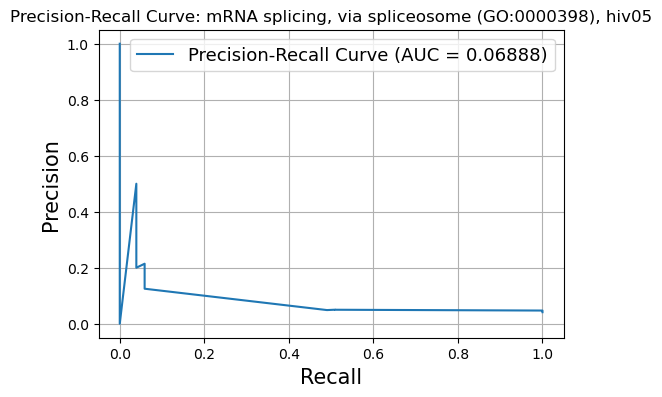

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_precision_recall:.5f})')
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.title('Precision-Recall Curve: mRNA splicing, via spliceosome (GO:0000398), hiv05', fontsize=12)
plt.legend(loc='best', fontsize=13)
plt.grid(True)
plt.show()

#### Listing the biological processes for the proteins found in ensemble network

In [12]:
go0000398_hiv05_count_df = build_biological_process_count_df(go0000398_ensemble05_prc_df, go0000398_df)
go0000398_hiv05_count_df[go0000398_hiv05_count_df['Count'] > 4]

51


,Element,Count
0,"mRNA splicing, via spliceosome [GO:0000398]",44
1,RNA splicing [GO:0008380],13
2,"negative regulation of mRNA splicing, via spli...",9
3,mRNA processing [GO:0006397],9
4,"alternative mRNA splicing, via spliceosome [GO...",7
5,"RNA splicing, via transesterification reaction...",7
6,positive regulation of transcription by RNA po...,7
7,"regulation of alternative mRNA splicing, via s...",7
8,RNA processing [GO:0006396],6
9,spliceosomal complex assembly [GO:0000245],6


### 5 min: GO term --> cell division (GO:0051301)

In [13]:
go0051301_path = "C:/Users/sumed/BDS-SROP-24/spras_raw_data/uniprotkb_go_0051301_AND_taxonomy_id_96_2024_07_29.tsv"
go0051301_df = pd.read_csv(go0051301_path, sep='\t')
go0051301_df.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Gene Ontology (biological process)
0,A0A024R1X5,unreviewed,A0A024R1X5_HUMAN,Beclin-1,BECN1 hCG_16958,amyloid-beta metabolic process [GO:0050435]; a...
1,A0A0S2Z4N5,unreviewed,A0A0S2Z4N5_HUMAN,Tumor protein 63 (p63),TP63 TP73L hCG_16028,cellular senescence [GO:0090398]; chromatin re...
2,A0A140VK09,unreviewed,A0A140VK09_HUMAN,Calcium and integrin-binding protein 1 (Calmyrin),NaN,angiogenesis [GO:0001525]; apoptotic process [...
3,A0A2P9DU05,unreviewed,A0A2P9DU05_HUMAN,Rho-associated protein kinase (EC 2.7.11.1),ROCK2,actomyosin structure organization [GO:0031032]...
4,A0A2R8Y4I8,unreviewed,A0A2R8Y4I8_HUMAN,Spastin (EC 5.6.1.1),SPAST SPG4,axonogenesis [GO:0007409]; cytokinetic process...


In [14]:
go0051301_proteins_list = go0051301_df['Entry Name']
print("Number of proteins in GO:0051301 and human taxonomy: ", len(go0051301_proteins_list))
go0051301_ensemble05 = list(set(go0051301_proteins_list) & set(ensemble05_proteins_list))
print("Number of proteins in GO:0051301 and human taxonomy, intersected with SPRAS hiv05 ensemble pathway nodes: ", len(go0051301_ensemble05))

Number of proteins in GO:0051301 and human taxonomy:  1064
Number of proteins in GO:0051301 and human taxonomy, intersected with SPRAS hiv05 ensemble pathway nodes:  113


#### Building the PRC:

In [15]:
go0051301_ensemble05_prc_df = build_prc_df(ensemble05_df, go0051301_ensemble05)
go0051301_ensemble05_prc_df.head()

,Node,max_freq,y_go
0,1433B_HUMAN,0.16,0
1,1433E_HUMAN,0.16,0
2,1433G_HUMAN,0.16,0
3,1433S_HUMAN,0.12,0
4,1433T_HUMAN,0.16,0


In [16]:
# extract needed columns from df
y_true = go0051301_ensemble05_prc_df['y_go']
y_scores = go0051301_ensemble05_prc_df['max_freq']

In [17]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
# use avg precision score to calculate the area under the curve of precision recall curve
auc_precision_recall = average_precision_score(y_true, y_scores)
print(auc_precision_recall)

0.09764040405994252


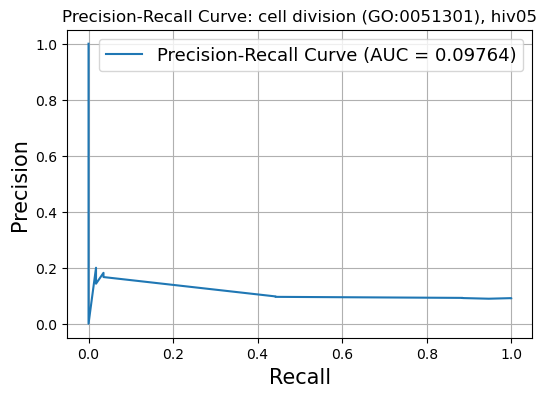

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_precision_recall:.5f})')
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.title('Precision-Recall Curve: cell division (GO:0051301), hiv05', fontsize=12)
plt.legend(loc='best', fontsize=13)
plt.grid(True)
plt.show()

#### Listing the biological processes for the proteins found in ensemble network

In [19]:
go0051301_hiv05_count_df = build_biological_process_count_df(go0051301_ensemble05_prc_df, go0051301_df)
go0051301_hiv05_count_df[go0051301_hiv05_count_df['Count'] > 8]

113


,Element,Count
0,cell division [GO:0051301],73
1,mitotic cytokinesis [GO:0000281],20
2,negative regulation of transcription by RNA po...,16
3,mitotic cell cycle [GO:0000278],14
4,mitotic spindle assembly [GO:0090307],14
5,protein phosphorylation [GO:0006468],11
6,microtubule cytoskeleton organization [GO:0000...,10
7,DNA repair [GO:0006281],10
8,chromosome segregation [GO:0007059],10
9,mitotic spindle organization [GO:0007052],10


### 5 min: GO term --> positive regulation of transcription from RNA polymerase II promoter	149 (GO:0045944)

In [20]:
go0045944_path = "C:/Users/sumed/BDS-SROP-24/spras_raw_data/uniprotkb_go_0045944_AND_taxonomy_id_96_2024_07_29.tsv"
go0045944_df = pd.read_csv(go0045944_path, sep='\t')
go0045944_df.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Gene Ontology (biological process)
0,A0A024R274,unreviewed,A0A024R274_HUMAN,Mothers against decapentaplegic homolog (MAD h...,SMAD4,adrenal gland development [GO:0030325]; atriov...
1,A0A024R5Z7,unreviewed,A0A024R5Z7_HUMAN,Annexin,ANXA2 hCG_2004404,angiogenesis [GO:0001525]; cell-matrix adhesio...
2,A0A0A0MQU7,unreviewed,A0A0A0MQU7_HUMAN,HNF1 homeobox A,HNF1A,apoptotic nuclear changes [GO:0030262]; bile a...
3,A0A0S2Z310,unreviewed,A0A0S2Z310_HUMAN,Serine/threonine-protein kinase receptor (EC 2...,ACVRL1,angiogenesis [GO:0001525]; blood vessel remode...
4,A0A0S2Z383,unreviewed,A0A0S2Z383_HUMAN,Homeobox protein Nkx-2.5 (Homeobox protein NK-...,NKX2-5,adult heart development [GO:0007512]; apoptoti...


In [21]:
go0045944_proteins_list = go0045944_df['Entry Name']
print("Number of proteins in GO:0045944 and human taxonomy: ", len(go0045944_proteins_list))
go0045944_ensemble05 = list(set(go0045944_proteins_list) & set(ensemble05_proteins_list))
print("Number of proteins in GO:0045944 and human taxonomy, intersected with SPRAS hiv05 ensemble pathway nodes: ", len(go0045944_ensemble05))

Number of proteins in GO:0045944 and human taxonomy:  2197
Number of proteins in GO:0045944 and human taxonomy, intersected with SPRAS hiv05 ensemble pathway nodes:  191


#### Building the PRC:

In [22]:
go0045944_ensemble05_prc_df = build_prc_df(ensemble05_df, go0045944_ensemble05)
go0045944_ensemble05_prc_df.head()

,Node,max_freq,y_go
0,1433B_HUMAN,0.16,0
1,1433E_HUMAN,0.16,0
2,1433G_HUMAN,0.16,0
3,1433S_HUMAN,0.12,0
4,1433T_HUMAN,0.16,0


In [23]:
# extract needed columns from df
y_true = go0045944_ensemble05_prc_df['y_go']
y_scores = go0045944_ensemble05_prc_df['max_freq']

In [24]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
# use avg precision score to calculate the area under the curve of precision recall curve
auc_precision_recall = average_precision_score(y_true, y_scores)
print(auc_precision_recall)

0.18626784334728516


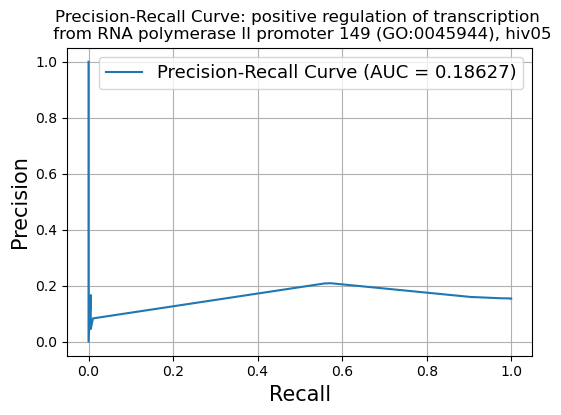

In [25]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_precision_recall:.5f})')
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.title('Precision-Recall Curve: positive regulation of transcription \n from RNA polymerase II promoter 149 (GO:0045944), hiv05', fontsize=12)
plt.legend(loc='best', fontsize=13)
plt.grid(True)
plt.show()

#### Listing the biological processes for the proteins found in ensemble network

In [26]:
go0045944_count_df = build_biological_process_count_df(go0045944_ensemble05_prc_df, go0045944_df)
go0045944_count_df[go0045944_count_df['Count'] > 20 ]

191


,Element,Count
0,positive regulation of transcription by RNA po...,174
1,regulation of transcription by RNA polymerase ...,75
2,positive regulation of DNA-templated transcrip...,68
3,negative regulation of transcription by RNA po...,66
4,transcription by RNA polymerase II [GO:0006366],38
5,negative regulation of DNA-templated transcrip...,38
6,positive regulation of gene expression [GO:001...,34
7,regulation of DNA-templated transcription [GO:...,32
8,negative regulation of cell population prolife...,26
9,chromatin remodeling [GO:0006338],26


## Part 2: Compare SPRAS hiv060 max node frequency and GO terms

### Load hiv060 max ensemble node frequency

In [27]:
ensemble060_df = pd.read_csv("C:/Users/sumed/BDS-SROP-24/spras_processed_data/hiv060-max-node-freq-ensemble.csv")
ensemble060_df.head()

,Node,max_freq
0,1433B_HUMAN,0.04
1,1433E_HUMAN,0.04
2,1433G_HUMAN,0.04
3,1433T_HUMAN,0.04
4,2A5A_HUMAN,0.08


In [28]:
ensemble060_proteins_list = ensemble060_df['Node']
len(ensemble060_proteins_list)

1029

### 60 min: GO term --> cell division (GO:0051301)

In [29]:
go0051301_proteins_list = go0051301_df['Entry Name']
print("Number of proteins in GO:0051301 and human taxonomy: ", len(go0051301_proteins_list))
go0051301_ensemble060 = list(set(go0051301_proteins_list) & set(ensemble060_proteins_list))
print("Number of proteins in GO:0051301 and human taxonomy, intersected with SPRAS hiv060 ensemble pathway nodes: ", len(go0051301_ensemble060))

Number of proteins in GO:0051301 and human taxonomy:  1064
Number of proteins in GO:0051301 and human taxonomy, intersected with SPRAS hiv060 ensemble pathway nodes:  101


#### Build PRC

In [30]:
go0051301_ensemble060_prc_df = build_prc_df(ensemble060_df, go0051301_ensemble060)
go0051301_ensemble060_prc_df.head()

,Node,max_freq,y_go
0,1433B_HUMAN,0.04,0
1,1433E_HUMAN,0.04,0
2,1433G_HUMAN,0.04,0
3,1433T_HUMAN,0.04,0
4,2A5A_HUMAN,0.08,0


In [31]:
# extract needed columns from df
y_true = go0051301_ensemble060_prc_df['y_go']
y_scores = go0051301_ensemble060_prc_df['max_freq']

In [32]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
# use avg precision score to calculate the area under the curve of precision recall curve
auc_precision_recall = average_precision_score(y_true, y_scores)
print(auc_precision_recall)

0.11148581561911794


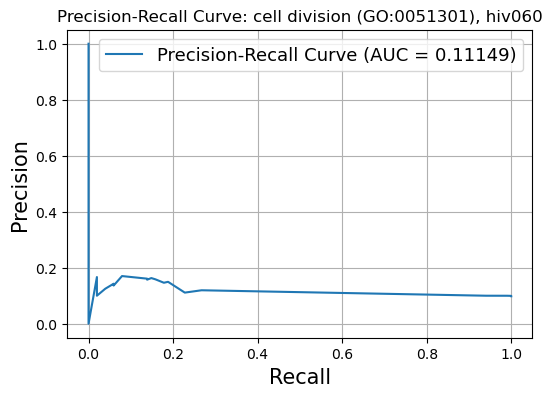

In [33]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_precision_recall:.5f})')
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.title('Precision-Recall Curve: cell division (GO:0051301), hiv060', fontsize=12)
plt.legend(loc='best', fontsize=13)
plt.grid(True)
plt.show()

In [34]:
go0051301_hiv060_count_df = build_biological_process_count_df(go0051301_ensemble060_prc_df, go0051301_df)
go0051301_hiv060_count_df[go0051301_hiv060_count_df['Count'] > 10]

101


,Element,Count
0,cell division [GO:0051301],75
1,mitotic cytokinesis [GO:0000281],17
2,mitotic spindle organization [GO:0007052],13
3,negative regulation of transcription by RNA po...,13
4,microtubule cytoskeleton organization [GO:0000...,13
5,mitotic cell cycle [GO:0000278],13
6,mitotic spindle assembly [GO:0090307],12
7,protein phosphorylation [GO:0006468],12


### 60 min: GO term --> mRNA splicing, via spliceosome (GO:0000398)

In [35]:
go0000398_proteins_list = go0000398_df['Entry Name']
print("Number of proteins in GO:0000398 and human taxonomy: ", len(go0000398_proteins_list))
go0000398_ensemble060 = list(set(go0000398_proteins_list) & set(ensemble060_proteins_list))
print("Number of proteins in GO:0000398 and human taxonomy, intersected with SPRAS hiv060 ensemble pathway nodes: ", len(go0000398_ensemble060))

Number of proteins in GO:0000398 and human taxonomy:  677
Number of proteins in GO:0000398 and human taxonomy, intersected with SPRAS hiv060 ensemble pathway nodes:  52


#### Build the PRC:

In [36]:
go0000398_ensemble060_prc_df = build_prc_df(ensemble060_df, go0000398_ensemble060)
go0000398_ensemble060_prc_df.head()

,Node,max_freq,y_go
0,1433B_HUMAN,0.04,0
1,1433E_HUMAN,0.04,0
2,1433G_HUMAN,0.04,0
3,1433T_HUMAN,0.04,0
4,2A5A_HUMAN,0.08,0


In [37]:
# extract needed columns from df
y_true = go0000398_ensemble060_prc_df['y_go']
y_scores = go0000398_ensemble060_prc_df['max_freq']

In [38]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
# use avg precision score to calculate the area under the curve of precision recall curve
auc_precision_recall = average_precision_score(y_true, y_scores)
print(auc_precision_recall)

0.051246600774379085


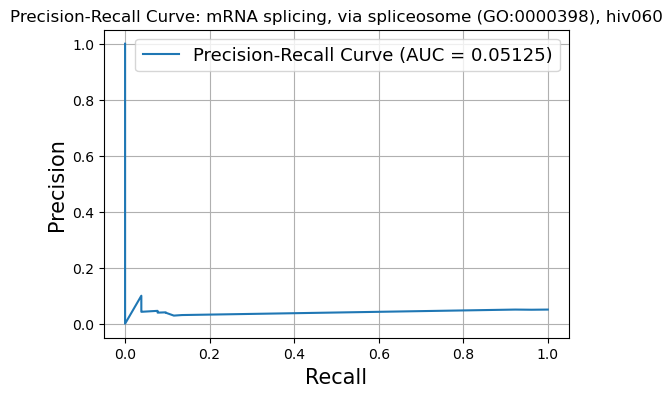

In [39]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_precision_recall:.5f})')
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.title('Precision-Recall Curve: mRNA splicing, via spliceosome (GO:0000398), hiv060', fontsize=12)
plt.legend(loc='best', fontsize=13)
plt.grid(True)
plt.show()

#### Listing the biological processes for the proteins found in ensemble network

In [40]:
go0000398_hiv060_count_df = build_biological_process_count_df(go0000398_ensemble060_prc_df, go0000398_df)
go0000398_hiv060_count_df[go0000398_hiv060_count_df['Count'] > 4]

52


,Element,Count
0,"mRNA splicing, via spliceosome [GO:0000398]",42
1,RNA splicing [GO:0008380],15
2,mRNA processing [GO:0006397],12
3,positive regulation of transcription by RNA po...,9
4,"regulation of alternative mRNA splicing, via s...",9
5,"negative regulation of mRNA splicing, via spli...",9
6,spliceosomal complex assembly [GO:0000245],9
7,"RNA splicing, via transesterification reaction...",8
8,spliceosomal tri-snRNP complex assembly [GO:00...,7
9,"positive regulation of mRNA splicing, via spli...",7


### 60 min: GO term --> cell-cell adhesion (GO:0098609)

In [41]:
go0098609_path = "C:/Users/sumed/BDS-SROP-24/spras_raw_data/uniprotkb_go_0098609_AND_taxonomy_id_96_2024_07_29.tsv"
go0098609_df = pd.read_csv(go0098609_path, sep='\t')
go0098609_df.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Gene Ontology (biological process)
0,A0A024R5Z7,unreviewed,A0A024R5Z7_HUMAN,Annexin,ANXA2 hCG_2004404,angiogenesis [GO:0001525]; cell-matrix adhesio...
1,A0A0U2ZQU7,unreviewed,A0A0U2ZQU7_HUMAN,Cadherin-1 (Epithelial cadherin),CDH1,adherens junction organization [GO:0034332]; c...
2,A0A140VJM0,unreviewed,A0A140VJM0_HUMAN,Testicular tissue protein Li 96 (Testicular ti...,NaN,cell adhesion mediated by integrin [GO:0033627...
3,A0A1U9X8X8,unreviewed,A0A1U9X8X8_HUMAN,Corneodesmosin,NaN,cell-cell adhesion [GO:0098609]; skin morphoge...
4,A0A384MDY0,unreviewed,A0A384MDY0_HUMAN,Catenin alpha-1,CTNNA1 hCG_1782385,apical junction assembly [GO:0043297]; axon re...


In [42]:
go0098609_proteins_list = go0098609_df['Entry Name']
print("Number of proteins in GO:0098609 and human taxonomy: ", len(go0098609_proteins_list))
go0098609_ensemble060 = list(set(go0098609_proteins_list) & set(ensemble060_proteins_list))
print("Number of proteins in GO:0098609 and human taxonomy, intersected with SPRAS hiv060 ensemble pathway nodes: ", len(go0098609_ensemble060))

Number of proteins in GO:0098609 and human taxonomy:  1308
Number of proteins in GO:0098609 and human taxonomy, intersected with SPRAS hiv060 ensemble pathway nodes:  24


#### Build the PRC

In [43]:
go0098609_ensemble060_prc_df = build_prc_df(ensemble060_df, go0098609_ensemble060)
go0098609_ensemble060_prc_df.head()

,Node,max_freq,y_go
0,1433B_HUMAN,0.04,0
1,1433E_HUMAN,0.04,0
2,1433G_HUMAN,0.04,0
3,1433T_HUMAN,0.04,0
4,2A5A_HUMAN,0.08,0


In [44]:
# extract needed columns from df
y_true = go0098609_ensemble060_prc_df['y_go']
y_scores = go0098609_ensemble060_prc_df['max_freq']

In [45]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
# use avg precision score to calculate the area under the curve of precision recall curve
auc_precision_recall = average_precision_score(y_true, y_scores)
print(auc_precision_recall)

0.023102923753173847


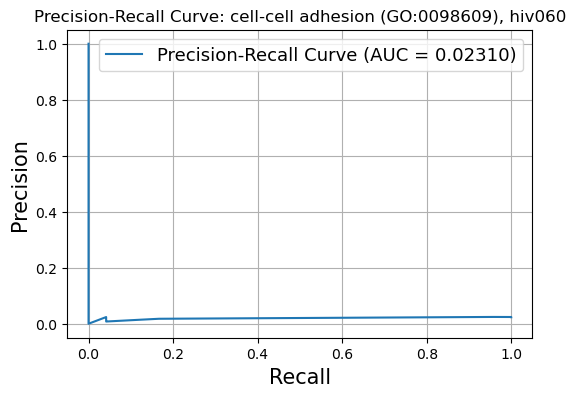

In [46]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_precision_recall:.5f})')
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.title('Precision-Recall Curve: cell-cell adhesion (GO:0098609), hiv060', fontsize=12)
plt.legend(loc='best', fontsize=13)
plt.grid(True)
plt.show()

#### Listing the biological processes for the proteins found in ensemble network

In [47]:
go0098609_hiv060_count_df = build_biological_process_count_df(go0098609_ensemble060_prc_df, go0098609_df)
go0098609_hiv060_count_df[go0098609_hiv060_count_df['Count'] > 4]

24


,Element,Count
0,cell-cell adhesion [GO:0098609],10
1,intracellular signal transduction [GO:0035556],7
2,signal transduction [GO:0007165],7
3,actin cytoskeleton organization [GO:0030036],6
4,peptidyl-tyrosine phosphorylation [GO:0018108],6
5,response to xenobiotic stimulus [GO:0009410],6
6,positive regulation of DNA-templated transcrip...,6
7,positive regulation of apoptotic process [GO:0...,6
8,negative regulation of apoptotic process [GO:0...,6
9,thymus development [GO:0048538],5
